# Funções

In [3]:
import time
#-----------------------------------------------------------------------------------
#          Função que plota circulos de distância em geral
#-----------------------------------------------------------------------------------
def evm_plota_aneis_em_geral(aneis, lon_r, lat_r, color, label):

    """
    Retorna círculos de distância centrado no radar

    Parâmetros de entrada:
                           aneis (lista): tamanho do raio do círculo em km
                           lon_r (float): valor da longitude do centro do círculo em graus
                           lat_r (float): valor da latitude do centro do círculo em graus
                           color (str): cor do raio do círculo
                           label (str): legenda

    Parâmetros de saída:
                         latitude e longitude que delimitam os círculos de distância centrado no radar e plota os círculos

    Exemplo:
             evm_plota_aneis_em_geral([100], -45.97279, -23.600795, 'gray', label='Radar: 100 km')
    """

    import geopy                              # Biblioteca para geocodificação
    from geopy import distance                # Função para calculo de distância
    import numpy as np                        # Biblioteca para trabalhar com matrizes

    origin = geopy.Point(lat_r, lon_r)

    lons = np.zeros((len(aneis), 361))
    lats = np.zeros((len(aneis), 361))
    for i, dis in enumerate(aneis):
        xpts = []
        ypts = []
        for az in range(361):
            destination = distance.distance(kilometers=dis).destination(origin, az)
            lat2, lon2 = destination.latitude, destination.longitude
            xpts.append(lon2)
            ypts.append(lat2)
        lons[i,:] = xpts[:]
        lats[i,:] = ypts[:]

    for i, anel in enumerate(aneis):
        ax.plot(lons[i,:], lats[i,:], color=color, label= label)

#-----------------------------------------------------------------------------------
#          Função que plota o APPI de reflatividade
#-----------------------------------------------------------------------------------
def plota_cappi_z(cappi, ano, mes, dia, hora, min, lon_radar, lat_radar, altitude, path_output):


    """
    Retorna a plotagem dos contornos de um shapefile na figura

    Parâmetros de entrada:
                shapefile (shp): shapefile da regiao

    Parâmetros de saída:
                figura com o contorno da região baseado no shapefile fornecido
    """
    

    import matplotlib.pyplot as plt           # Biblioteca para gerar gráficos
    import cartopy.crs as ccrs                # Biblioteca para trabalhar com projeções de mapas
    import geopy                              # Biblioteca para geocodificação
    from geopy import distance                # Função para calculo de distância
    import numpy as np                        # Biblioteca para trabalhar com matrizes
    import os

    # define o tamanho da figura
    fig = plt.figure(figsize=(10,7))

    # define os eixos e projeção da figura
    ax = fig.add_subplot(111, projection=ccrs.PlateCarree())

    # monta um objeto "display" do Py-ART
    display = pyart.graph.GridMapDisplay(cappi)

    # plota o cappi
    display.plot_grid("corrected_reflectivity",
                      level=0,
                      vmin=0,
                      vmax=70,
                      ax=ax,
                      cmap='pyart_NWSRef',
                      colorbar_label='Refletividade (dBZ)')

    # plotas as linhas passando pelo radar
    display.plot_crosshairs(lon=lon_radar, lat=lat_radar)

    # plota os aneis de distância do radar
    aneis = [100, 250]
    origin = geopy.Point(lat_radar, lon_radar)

    lons = np.zeros((len(aneis), 361))
    lats = np.zeros((len(aneis), 361))
    for i, dis in enumerate(aneis):
        xpts = []
        ypts = []
        for az in range(361):
            destination = distance.distance(kilometers=dis).destination(origin, az)
            lat2, lon2 = destination.latitude, destination.longitude
            xpts.append(lon2)
            ypts.append(lat2)
        lons[i,:] = xpts[:]
        lats[i,:] = ypts[:]

    for i, anel in enumerate(aneis):
        ax.plot(lons[i,:], lats[i,:], color='gray', label= dis)

    # título da figura
    plt.title(f'CAPPI {int(display.grid.z["data"][0]) + altitude} m - Refletividade: {ano}{mes}{dia} {hor}{min} UTC', fontsize=10)

    # nome dos eixos x e y
    ax.set_xlabel('Longitude ($\degree$)', fontsize=15)
    ax.set_ylabel('Latitude ($\degree$)', fontsize=15)

    # recorta figura
    plt.tight_layout()
    
    # salva figura
    plt.savefig(f'{path_output}/cappi_3000_Z_{ano}{mes}{dia}_{hor}{min}.png', dpi=300)

# Processamento

.... PROECESSANDO DATA= 2023 02 19 00 00
CPU times: total: 11.6 s
Wall time: 18.6 s


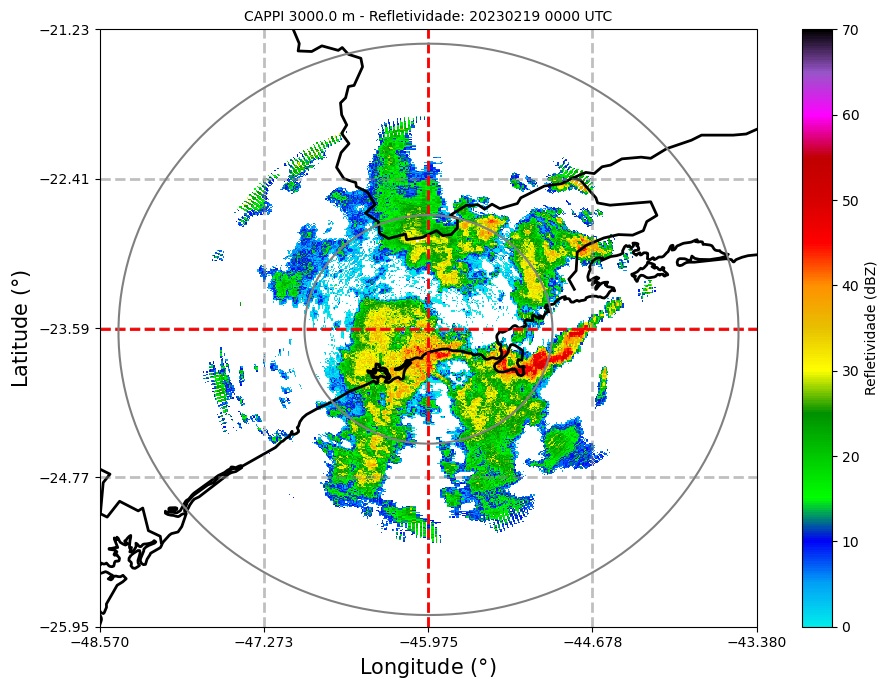

In [4]:
%%time
#========================================================================================================================#
#                                             IMPORTA BIBLIOTECAS
#========================================================================================================================#
import pyart
import glob
import os
import warnings
warnings.filterwarnings('ignore')

#========================================================================================================================#
#                                             CAMINHO DOS DIRETÓRIOS
#========================================================================================================================#
dir_input = 'input/2023-02-19'
dir_output = 'output/tif_cappi_refletividade'

#========================================================================================================================#
#                                             IMPORTA BIBLIOTECAS
#========================================================================================================================#
# lista os arquivos do radar
files = sorted(glob.glob(f'{dir_input}/*.HDF5')) ; files=files[0:1]

# loop dos arquivos
for file in files:
    
    #-------------------------------------------------------#
    #            LEITURA DO DADO DE RADAR
    #-------------------------------------------------------#
    # leitura do arquivo
    radar = pyart.aux_io.read_gamic(file)

    # extrai a latitude, longitude e altitude do radar
    lat_radar, lon_radar = radar.latitude['data'][0], radar.longitude['data'][0]
    altitude = radar.altitude['data'][0]

    # extrai a data do dado do radar
    data = pyart.util.datetime_from_grid(radar)

    # extra a data da imagem
    ano = str(data.year)
    mes = str(data.month).zfill(2)
    dia = str(data.day).zfill(2)
    hor = str(data.hour).zfill(2)
    min = str(data.minute).zfill(2)
    print('.... PROECESSANDO DATA=', ano,mes,dia,hor,min)

    #-------------------------------------------------------#
    #          DEFINIÇÕES DA GRADE DO CAPPI
    #-------------------------------------------------------#
    # função que calcula a quantidade de pontos em x, y e z
    def compute_number_of_points(extent, resolution):
        return int((extent[1] - extent[0]) / resolution)

    # limites da grade
    z_grid_limits = (3000. - altitude, 3000. - altitude)
    y_grid_limits = (-250_000., 250_000.)
    x_grid_limits = (-250_000., 250_000.)

    # resolução da grade em metros
    grid_resolution = 1000

    # pontos em X, Y e Z
    x_grid_points = compute_number_of_points(x_grid_limits, grid_resolution)
    y_grid_points = compute_number_of_points(y_grid_limits, grid_resolution)
    z_grid_points = 1
    
    #-------------------------------------------------------#
    #                   GERA CAPPI
    #-------------------------------------------------------#
    cappi = pyart.map.grid_from_radars(radar,
                                       grid_shape = (z_grid_points,
                                                     y_grid_points,
                                                     x_grid_points),
                                       grid_limits = (z_grid_limits,     # alturas
                                                      y_grid_limits,     # latitudes
                                                      x_grid_limits),    # longitudes
                                       grid_origin=(lat_radar, lon_radar),
                                       gridding_algo='map_gates_to_grid',
                                       roi_func='dist_beam',
                                       min_radius=1750.0,
                                       weighting_function='Nearest',
                                       fields=['corrected_reflectivity'])

    # cria a pasta de saídade com o nome "output"
    os.makedirs(f'{dir_output}/{ano}-{mes}-{dia}', exist_ok=True)
    
    # plota cappi
    plota_cappi_z(cappi, ano, mes, dia, hor, min, lon_radar, lat_radar, altitude, f'{dir_output}/{ano}-{mes}-{dia}')